In [2]:
%matplotlib inline


# Estimate the prediction intervals of 1D heteroscedastic data

:class:`~mapie.regression.MapieRegressor` and
:class:`~mapie.quantile_regression.MapieQuantileRegressor` is used
to estimate the prediction intervals of 1D heteroscedastic data using
different strategies. The latter class should provide the same
coverage for a lower width of intervals because it adapts the prediction
intervals to the local heteroscedastic noise.


In [5]:
from typing import Tuple

import numpy as np
import scipy
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, QuantileRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

from mapie._typing import NDArray
from mapie.regression import MapieQuantileRegressor, MapieRegressor
from mapie.subsample import Subsample

random_state = 42

In [6]:
def f(x: NDArray) -> NDArray:
    """Polynomial function used to generate one-dimensional data"""
    return np.array(5 * x + 5 * x ** 4 - 9 * x ** 2)

In [7]:
def get_heteroscedastic_data(
    n_train: int = 200, n_true: int = 200, sigma: float = 0.1
) -> Tuple[NDArray, NDArray, NDArray, NDArray, NDArray]:
    """
    Generate one-dimensional data from a given function,
    number of training and test samples and a given standard
    deviation increases linearly with x.
    The training data data is generated from an exponential distribution.

    Parameters
    ----------
    n_train : int, optional
        Number of training samples, by default  200.
    n_true : int, optional
        Number of test samples, by default 1000.
    sigma : float, optional
        Standard deviation of noise, by default 0.1

    Returns
    -------
    Tuple[NDArray, NDArray, NDArray, NDArray, NDArray]
        Generated training and test data.
        [0]: X_train
        [1]: y_train
        [2]: X_true
        [3]: y_true
        [4]: y_true_sigma
    """
    np.random.seed(random_state)
    q95 = scipy.stats.norm.ppf(0.95)        # 1.6448536269514722
    X_train = np.linspace(0, 1, n_train)
    y_train = f(X_train) + np.random.normal(0, sigma, n_train) * X_train
    X_true = np.linspace(0, 1, n_true)
    y_true = f(X_true)
    y_true_sigma = q95 * sigma * X_true     # 0.1 * 1.6448536269514722 * X_true
    return X_train, y_train, X_true, y_true, y_true_sigma

In [11]:
    # n_train= 10
    # n_true= 15
    # sigma = 0.1
    # np.random.seed(random_state)
    # q95 = scipy.stats.norm.ppf(0.95)        # 1.6448536269514722
    # X_train = np.linspace(0, 1, n_train)
    # X_true = np.linspace(0, 1, n_true)
    # y_train = f(X_train) + np.random.normal(0, sigma, n_train) * X_train
    # y_true = f(X_true)
    # y_true_sigma = q95 * sigma * X_true

In [12]:
# y_true_sigma

array([0.        , 0.01174895, 0.02349791, 0.03524686, 0.04699582,
       0.05874477, 0.07049373, 0.08224268, 0.09399164, 0.10574059,
       0.11748954, 0.1292385 , 0.14098745, 0.15273641, 0.16448536])

In [8]:
def plot_1d_data(
    X_train: NDArray,
    y_train: NDArray,
    X_test: NDArray,
    y_test: NDArray,
    y_test_sigma: NDArray,
    y_pred: NDArray,
    y_pred_low: NDArray,
    y_pred_up: NDArray,
    ax: plt.Axes,
    title: str,
) -> None:
    """
    Generate a figure showing the training data and estimated
    prediction intervals on test data.

    Parameters
    ----------
    X_train : NDArray
        Training data.
    y_train : NDArray
        Training labels.
    X_test : NDArray
        Test data.
    y_test : NDArray
        True function values on test data.
    y_test_sigma : float
        True standard deviation.
    y_pred : NDArray
        Predictions on test data.
    y_pred_low : NDArray
        Predicted lower bounds on test data.
    y_pred_up : NDArray
        Predicted upper bounds on test data.
    ax : plt.Axes
        Axis to plot.
    title : str
        Title of the figure.
    """
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.scatter(X_train, y_train, color="red", alpha=0.3, label="training")
    ax.plot(X_test, y_test, color="gray", label="True confidence intervals")
    ax.plot(X_test, y_test - y_test_sigma, color="gray", ls="--")
    ax.plot(X_test, y_test + y_test_sigma, color="gray", ls="--")
    ax.plot(X_test, y_pred, label="Prediction intervals")
    ax.fill_between(X_test, y_pred_low, y_pred_up, alpha=0.3)
    ax.set_title(title)
    ax.legend()

c:\Users\ryees\anaconda3\envs\pc1\Lib\site-packages\mapie\utils.py:534: UserWarning: WARNING: The predictions have issues.
The upper predictions are lower thanthe lower predictions at some points.
  warnings.warn(


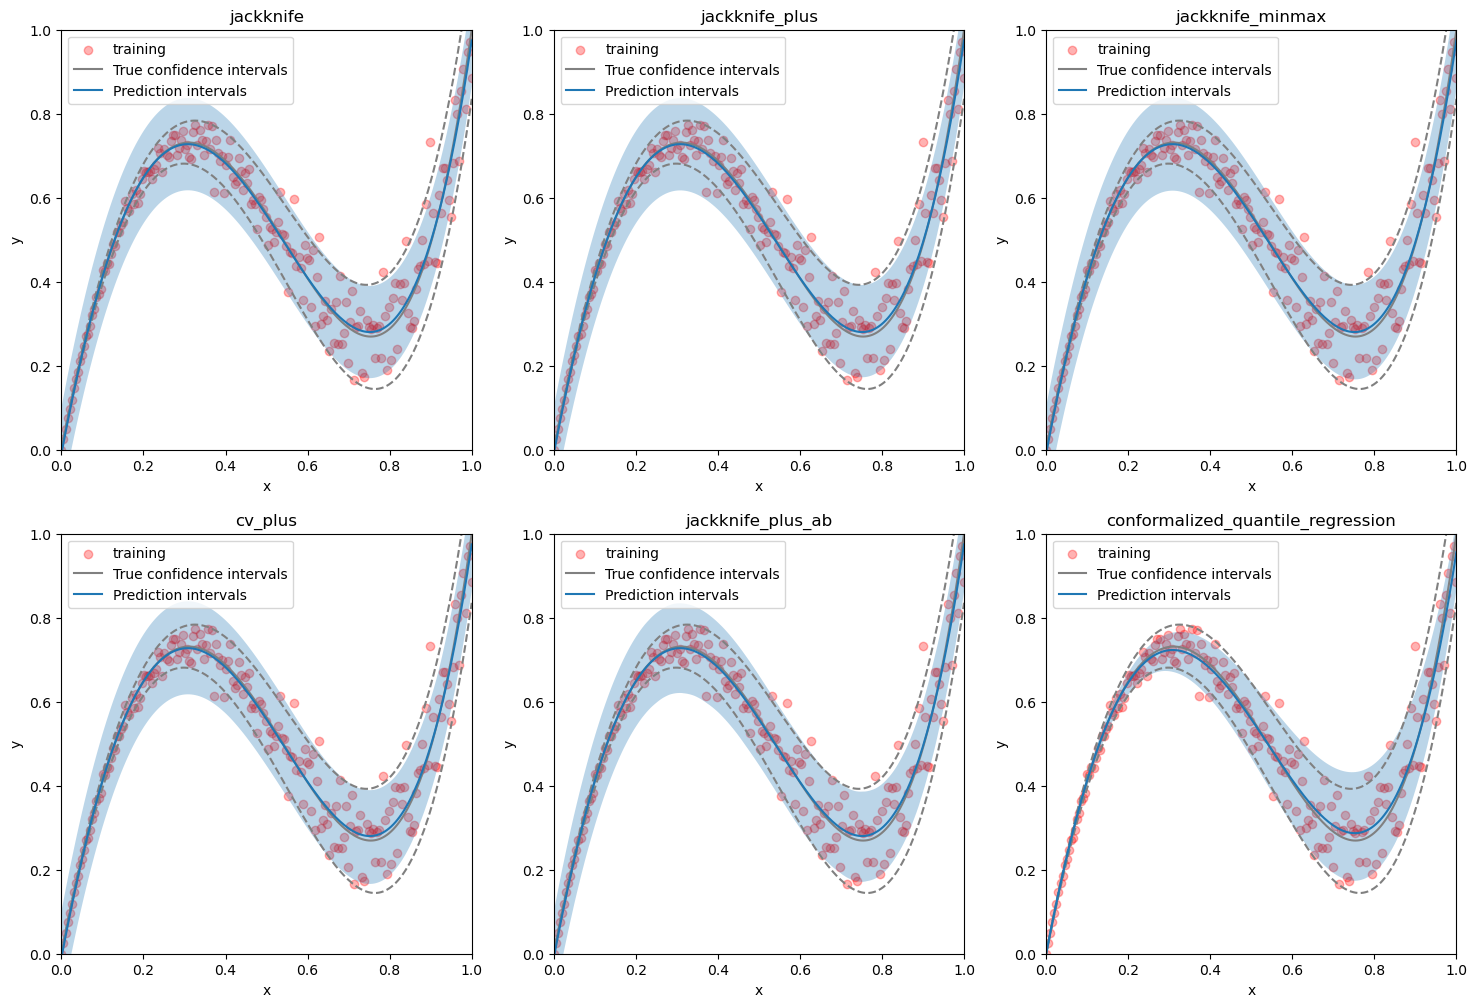

In [4]:
X_train, y_train, X_test, y_test, y_test_sigma = get_heteroscedastic_data()

polyn_model = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=4)),
        ("linear", LinearRegression()),
    ]
)
polyn_model_quant = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=4)),
        ("linear", QuantileRegressor(
            solver="highs-ds",
            alpha=0,
        )),
    ]
)

STRATEGIES = {
    "jackknife": {"method": "base", "cv": -1},
    "jackknife_plus": {"method": "plus", "cv": -1},
    "jackknife_minmax": {"method": "minmax", "cv": -1},
    "cv_plus": {"method": "plus", "cv": 10},
    "jackknife_plus_ab": {"method": "plus", "cv": Subsample(n_resamplings=50)},
    "conformalized_quantile_regression": {"method": "quantile", "cv": "split"},
}
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(
    2, 3, figsize=(3 * 6, 12)
)
axs = [ax1, ax2, ax3, ax4, ax5, ax6]
for i, (strategy, params) in enumerate(STRATEGIES.items()):
    if strategy == "conformalized_quantile_regression":
        mapie = MapieQuantileRegressor(  # type: ignore
            polyn_model_quant,
            **params
        )
        mapie.fit(X_train.reshape(-1, 1), y_train, random_state=random_state)
        y_pred, y_pis = mapie.predict(X_test.reshape(-1, 1))
    else:
        mapie = MapieRegressor(  # type: ignore
            polyn_model,
            agg_function="median",
            n_jobs=-1,
            **params
        )
        mapie.fit(X_train.reshape(-1, 1), y_train)
        y_pred, y_pis = mapie.predict(
            X_test.reshape(-1, 1),
            alpha=0.05,
        )
    plot_1d_data(
        X_train,
        y_train,
        X_test,
        y_test,
        y_test_sigma,
        y_pred,
        y_pis[:, 0, 0],
        y_pis[:, 1, 0],
        axs[i],
        strategy,
    )
plt.show()